In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

/home/youlee/n24news/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_path = '/home/youlee/n24news/n24news/captions_and_labels.csv'

categories = [
    "Opinion", "Art & Design", "Television", "Music", "Travel",
    "Real Estate", "Books", "Theater", "Health", "Sports",
    "Science", "Food", "Fashion & Style", "Movies", "Technology",
    "Dance", "Media", "Style"
]

data = pd.read_csv(file_path)
filtered_data = data[data['Label'].isin(categories)]


label_groups = [categories[i:i + 3] for i in range(0, len(categories), 3)]
group_files = []
for i, group in enumerate(label_groups, start=1):
    group_data = filtered_data[filtered_data['Label'].isin(group)]
    output_file_path = f'/home/youlee/n24news/n24news/group_{i}.csv'
    group_data.to_csv(output_file_path, index=False)
    group_files.append(output_file_path)

print("Grouped data files saved:")
for file in group_files:
    print(file)

Grouped data files saved:
/home/youlee/n24news/n24news/group_1.csv
/home/youlee/n24news/n24news/group_2.csv
/home/youlee/n24news/n24news/group_3.csv
/home/youlee/n24news/n24news/group_4.csv
/home/youlee/n24news/n24news/group_5.csv
/home/youlee/n24news/n24news/group_6.csv


In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LENGTH = 128

def tokenize_data(df):
    input_ids, attention_masks = [], []
    
    df['Caption'] = df['Caption'].astype(str).fillna("")

    for text in df['Caption']:
        encoded = tokenizer(
            text, padding='max_length', truncation=True, max_length=MAX_LENGTH, return_tensors="pt"
        )
        input_ids.append(encoded['input_ids'].squeeze(0))
        attention_masks.append(encoded['attention_mask'].squeeze(0))
    return torch.stack(input_ids), torch.stack(attention_masks)


In [4]:
class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }

In [5]:
class CrossAttention(nn.Module):
    def __init__(self, d_in, d_out_kq, d_out_v):
        super(CrossAttention, self).__init__()
        self.key_proj = nn.Linear(d_in, d_out_kq)
        self.query_proj = nn.Linear(d_in, d_out_kq)
        self.value_proj = nn.Linear(d_in, d_out_v)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, latent):
        keys = self.key_proj(x)
        queries = self.query_proj(latent)
        values = self.value_proj(x)

        attention_scores = torch.matmul(queries, keys.transpose(-2, -1))
        attention_probs = self.softmax(attention_scores)

        attended_values = torch.matmul(attention_probs, values)
        return attended_values

class LatentTransformer(nn.Module):
    def __init__(self, latent_dim, num_heads, num_layers, embed_dim):
        super(LatentTransformer, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, latent):
        latent = latent.permute(1, 0, 2)
        latent = self.transformer(latent)
        return latent.permute(1, 0, 2)

class Averaging(nn.Module):
    def forward(self, latent):
        return latent.mean(dim=1)

class Perceiver(nn.Module):
    def __init__(self, vocab_size, embed_dim, latent_dim, num_heads, num_layers, num_classes):
        super(Perceiver, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.input_proj = nn.Linear(embed_dim, embed_dim)

        self.latents = nn.Parameter(torch.randn(1, latent_dim, embed_dim))
        self.cross_attention = CrossAttention(d_in=embed_dim, d_out_kq=embed_dim, d_out_v=embed_dim)
        self.latent_transformer = LatentTransformer(latent_dim=latent_dim, num_heads=num_heads,
                                                    num_layers=num_layers, embed_dim=embed_dim)
        self.averaging = Averaging()
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, input_ids, attention_mask):
        x = self.embedding(input_ids)
        x = self.input_proj(x)

        batch_size = x.size(0)
        latent = self.latents.repeat(batch_size, 1, 1)
        latent = self.cross_attention(x, latent)
        latent = self.latent_transformer(latent)
        latent_avg = self.averaging(latent)
        logits = self.classifier(latent_avg)
        return logits

In [6]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

In [7]:
def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

In [8]:
EPOCHS = 10
BATCH_SIZE = 32
results = []
VOCAB_SIZE = tokenizer.vocab_size
EMBED_DIM = 128
LATENT_DIM = 64
NUM_HEADS = 8
NUM_LAYERS = 4

In [9]:
results = []
all_learning_curves = []

for idx, group_file in enumerate(group_files, start=1):
    print(f"\nProcessing Group {idx}...")

    df = pd.read_csv(group_file)
    df['Label'] = LabelEncoder().fit_transform(df['Label'])

    input_ids, attention_masks = tokenize_data(df)
    labels = torch.tensor(df['Label'].values)

    dataset = CustomDataset(input_ids, attention_masks, labels)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    model = Perceiver(vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, latent_dim=LATENT_DIM,
                      num_heads=NUM_HEADS, num_layers=NUM_LAYERS, num_classes=len(df['Label'].unique()))
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Learning curve 저장용 리스트
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(EPOCHS):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        test_loss, test_acc = eval_epoch(model, test_loader, criterion, device)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        print(f'  Group {idx} Epoch {epoch+1}/{EPOCHS}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'                             Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

    # Learning curve 저장
    all_learning_curves.append({
        "Group": idx,
        "train_losses": train_losses,
        "test_losses": test_losses,
        "train_accuracies": train_accuracies,
        "test_accuracies": test_accuracies
    })

    # Confusion Matrix 계산
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Confusion Matrix와 Classification Report 저장
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True)
    results.append({
        "Group": idx,
        "Test Accuracy": test_acc,
        "Confusion Matrix": cm,
        "Classification Report": report
    })


Processing Group 1...


/home/youlee/n24news/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


  Group 1 Epoch 1/10: Train Loss: 0.7277, Train Acc: 0.6835
                             Test Loss: 0.5850, Test Acc: 0.7750
  Group 1 Epoch 2/10: Train Loss: 0.5208, Train Acc: 0.7988
                             Test Loss: 0.5024, Test Acc: 0.8134
  Group 1 Epoch 3/10: Train Loss: 0.4367, Train Acc: 0.8420
                             Test Loss: 0.4851, Test Acc: 0.8162
  Group 1 Epoch 4/10: Train Loss: 0.3957, Train Acc: 0.8568
                             Test Loss: 0.4543, Test Acc: 0.8402
  Group 1 Epoch 5/10: Train Loss: 0.3518, Train Acc: 0.8715
                             Test Loss: 0.4859, Test Acc: 0.8189
  Group 1 Epoch 6/10: Train Loss: 0.3057, Train Acc: 0.8909
                             Test Loss: 0.4478, Test Acc: 0.8306
  Group 1 Epoch 7/10: Train Loss: 0.2624, Train Acc: 0.9086
                             Test Loss: 0.4458, Test Acc: 0.8416
  Group 1 Epoch 8/10: Train Loss: 0.2272, Train Acc: 0.9230
                             Test Loss: 0.5341, Test Acc: 0.8251


/home/youlee/n24news/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


  Group 2 Epoch 1/10: Train Loss: 0.8711, Train Acc: 0.6012
                             Test Loss: 0.7850, Test Acc: 0.6770
  Group 2 Epoch 2/10: Train Loss: 0.6678, Train Acc: 0.7205
                             Test Loss: 0.6558, Test Acc: 0.7426
  Group 2 Epoch 3/10: Train Loss: 0.5961, Train Acc: 0.7549
                             Test Loss: 0.6282, Test Acc: 0.7557
  Group 2 Epoch 4/10: Train Loss: 0.5111, Train Acc: 0.8004
                             Test Loss: 0.6088, Test Acc: 0.7709
  Group 2 Epoch 5/10: Train Loss: 0.4570, Train Acc: 0.8251
                             Test Loss: 0.5603, Test Acc: 0.7881
  Group 2 Epoch 6/10: Train Loss: 0.3980, Train Acc: 0.8453
                             Test Loss: 0.5978, Test Acc: 0.7881
  Group 2 Epoch 7/10: Train Loss: 0.3579, Train Acc: 0.8655
                             Test Loss: 0.6231, Test Acc: 0.7695
  Group 2 Epoch 8/10: Train Loss: 0.3281, Train Acc: 0.8755
                             Test Loss: 0.6178, Test Acc: 0.7840


/home/youlee/n24news/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


  Group 3 Epoch 1/10: Train Loss: 0.7602, Train Acc: 0.6649
                             Test Loss: 0.6030, Test Acc: 0.7531
  Group 3 Epoch 2/10: Train Loss: 0.5862, Train Acc: 0.7628
                             Test Loss: 0.5515, Test Acc: 0.7759
  Group 3 Epoch 3/10: Train Loss: 0.4928, Train Acc: 0.8077
                             Test Loss: 0.4603, Test Acc: 0.8050
  Group 3 Epoch 4/10: Train Loss: 0.4331, Train Acc: 0.8299
                             Test Loss: 0.4240, Test Acc: 0.8223
  Group 3 Epoch 5/10: Train Loss: 0.3846, Train Acc: 0.8551
                             Test Loss: 0.4198, Test Acc: 0.8285
  Group 3 Epoch 6/10: Train Loss: 0.3379, Train Acc: 0.8733
                             Test Loss: 0.4488, Test Acc: 0.8257
  Group 3 Epoch 7/10: Train Loss: 0.3061, Train Acc: 0.8895
                             Test Loss: 0.4253, Test Acc: 0.8368
  Group 3 Epoch 8/10: Train Loss: 0.2547, Train Acc: 0.9085
                             Test Loss: 0.4234, Test Acc: 0.8368


/home/youlee/n24news/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


  Group 4 Epoch 1/10: Train Loss: 0.9178, Train Acc: 0.5676
                             Test Loss: 0.7660, Test Acc: 0.6699
  Group 4 Epoch 2/10: Train Loss: 0.6645, Train Acc: 0.7217
                             Test Loss: 0.6298, Test Acc: 0.7396
  Group 4 Epoch 3/10: Train Loss: 0.5449, Train Acc: 0.7808
                             Test Loss: 0.5865, Test Acc: 0.7688
  Group 4 Epoch 4/10: Train Loss: 0.4424, Train Acc: 0.8297
                             Test Loss: 0.5459, Test Acc: 0.7779
  Group 4 Epoch 5/10: Train Loss: 0.3907, Train Acc: 0.8471
                             Test Loss: 0.5018, Test Acc: 0.8008
  Group 4 Epoch 6/10: Train Loss: 0.2966, Train Acc: 0.8912
                             Test Loss: 0.5330, Test Acc: 0.8127
  Group 4 Epoch 7/10: Train Loss: 0.2470, Train Acc: 0.9096
                             Test Loss: 0.5971, Test Acc: 0.7981
  Group 4 Epoch 8/10: Train Loss: 0.2036, Train Acc: 0.9232
                             Test Loss: 0.5762, Test Acc: 0.8252


/home/youlee/n24news/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


  Group 5 Epoch 1/10: Train Loss: 0.7495, Train Acc: 0.6527
                             Test Loss: 0.5904, Test Acc: 0.7530
  Group 5 Epoch 2/10: Train Loss: 0.5082, Train Acc: 0.7948
                             Test Loss: 0.5142, Test Acc: 0.7894
  Group 5 Epoch 3/10: Train Loss: 0.4244, Train Acc: 0.8326
                             Test Loss: 0.4967, Test Acc: 0.8083
  Group 5 Epoch 4/10: Train Loss: 0.3654, Train Acc: 0.8635
                             Test Loss: 0.4632, Test Acc: 0.8223
  Group 5 Epoch 5/10: Train Loss: 0.3171, Train Acc: 0.8788
                             Test Loss: 0.4882, Test Acc: 0.8209
  Group 5 Epoch 6/10: Train Loss: 0.2854, Train Acc: 0.8963
                             Test Loss: 0.4366, Test Acc: 0.8362
  Group 5 Epoch 7/10: Train Loss: 0.2407, Train Acc: 0.9108
                             Test Loss: 0.4407, Test Acc: 0.8390
  Group 5 Epoch 8/10: Train Loss: 0.1939, Train Acc: 0.9333
                             Test Loss: 0.4776, Test Acc: 0.8244


/home/youlee/n24news/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


  Group 6 Epoch 1/10: Train Loss: 0.8781, Train Acc: 0.5685
                             Test Loss: 0.6898, Test Acc: 0.7047
  Group 6 Epoch 2/10: Train Loss: 0.6147, Train Acc: 0.7327
                             Test Loss: 0.5948, Test Acc: 0.7476
  Group 6 Epoch 3/10: Train Loss: 0.5291, Train Acc: 0.7705
                             Test Loss: 0.5808, Test Acc: 0.7716
  Group 6 Epoch 4/10: Train Loss: 0.4849, Train Acc: 0.7942
                             Test Loss: 0.5362, Test Acc: 0.7833
  Group 6 Epoch 5/10: Train Loss: 0.4418, Train Acc: 0.8120
                             Test Loss: 0.5809, Test Acc: 0.7615
  Group 6 Epoch 6/10: Train Loss: 0.4050, Train Acc: 0.8327
                             Test Loss: 0.5685, Test Acc: 0.7760
  Group 6 Epoch 7/10: Train Loss: 0.3696, Train Acc: 0.8505
                             Test Loss: 0.5383, Test Acc: 0.7862
  Group 6 Epoch 8/10: Train Loss: 0.3286, Train Acc: 0.8691
                             Test Loss: 0.5540, Test Acc: 0.7840


In [10]:
# 결과 출력
for result in results:
    print(f"\nGroup {result['Group']} Results:")
    print(f"Test Accuracy: {result['Test Accuracy']:.4f}")
    print(pd.DataFrame(result['Classification Report']).transpose())


Group 1 Results:
Test Accuracy: 0.8306
              precision    recall  f1-score     support
0              0.824601  0.780172  0.801772   464.00000
1              0.825743  0.829026  0.827381   503.00000
2              0.840467  0.879837  0.859701   491.00000
accuracy       0.830590  0.830590  0.830590     0.83059
macro avg      0.830270  0.829678  0.829618  1458.00000
weighted avg   0.830338  0.830590  0.830115  1458.00000

Group 2 Results:
Test Accuracy: 0.8026
              precision    recall  f1-score      support
0              0.843478  0.827292  0.835307   469.000000
1              0.805221  0.810101  0.807654   495.000000
2              0.761711  0.771134  0.766393   485.000000
accuracy       0.802622  0.802622  0.802622     0.802622
macro avg      0.803470  0.802842  0.803118  1449.000000
weighted avg   0.803040  0.802622  0.802794  1449.000000

Group 3 Results:
Test Accuracy: 0.8382
              precision    recall  f1-score      support
0              0.739300  0.83885

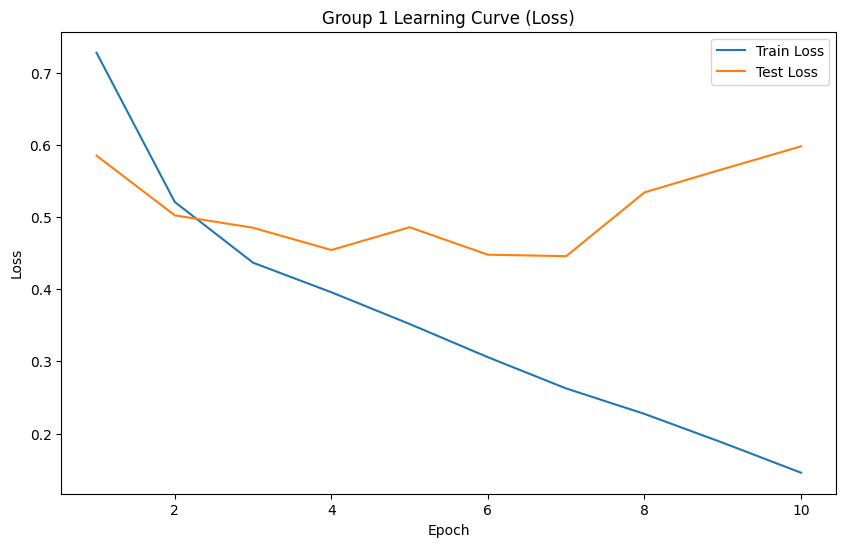

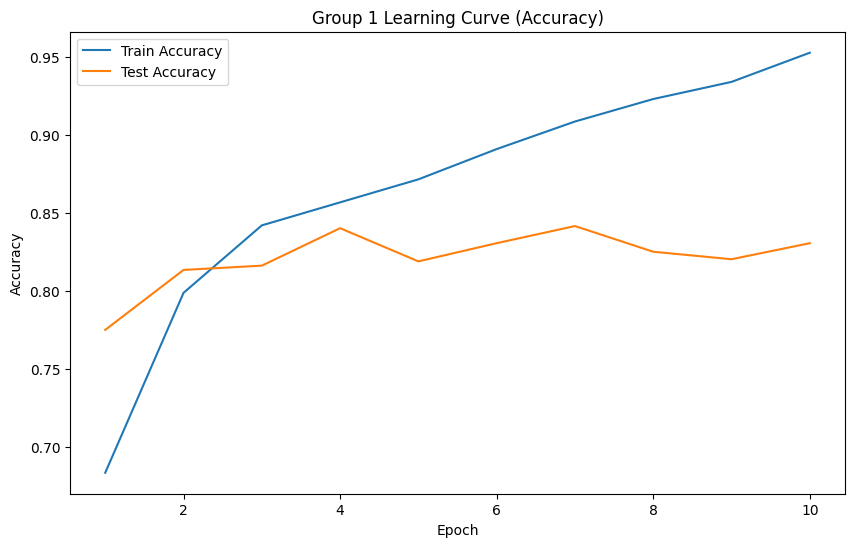

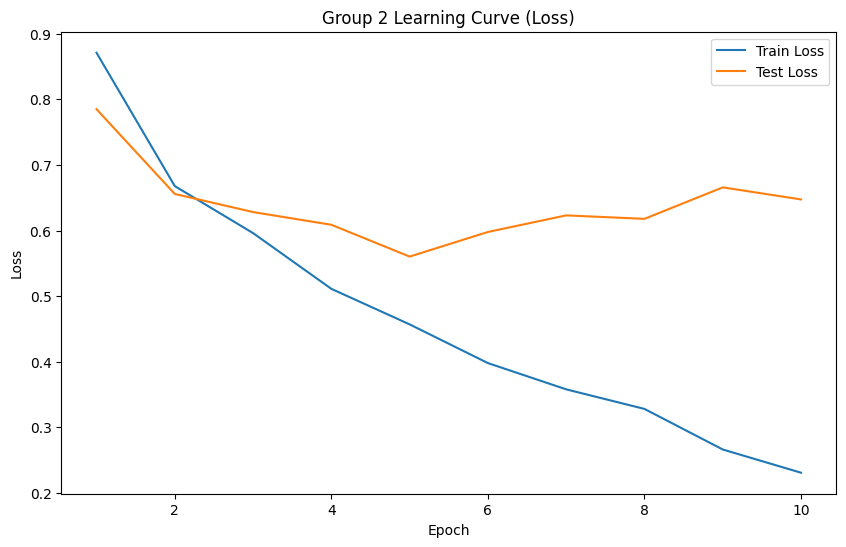

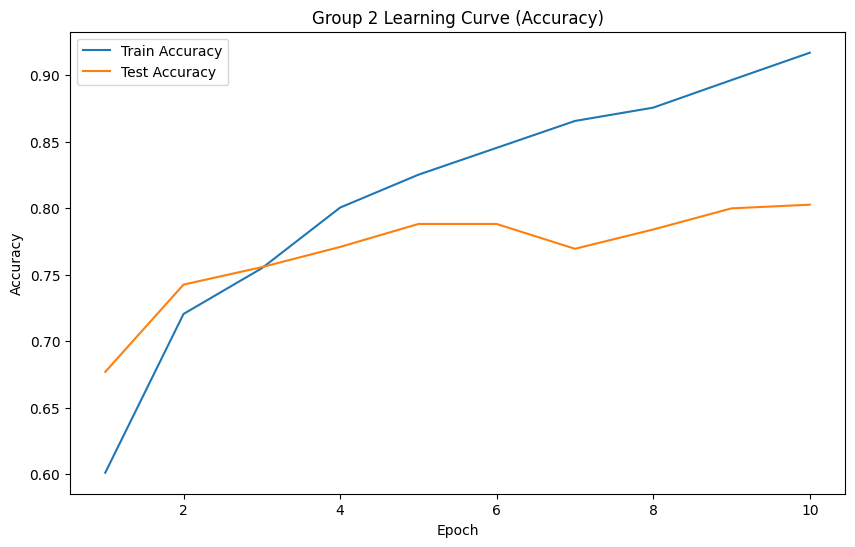

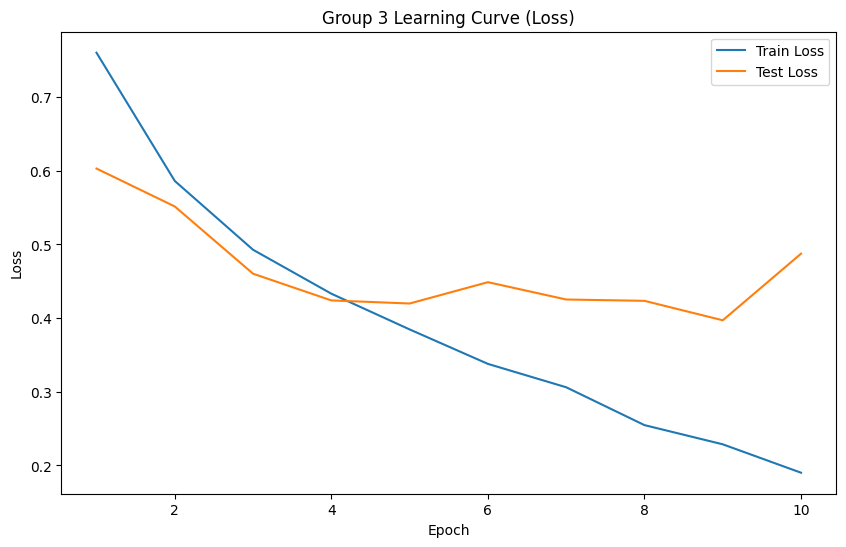

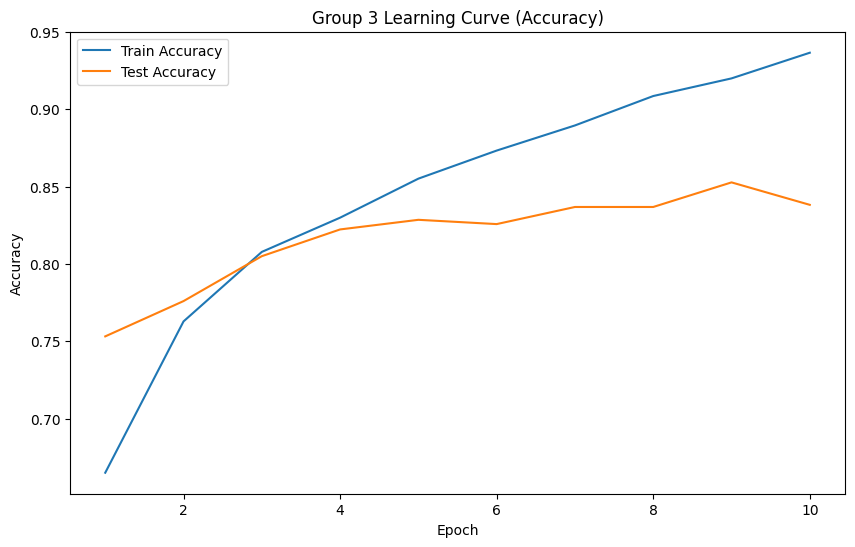

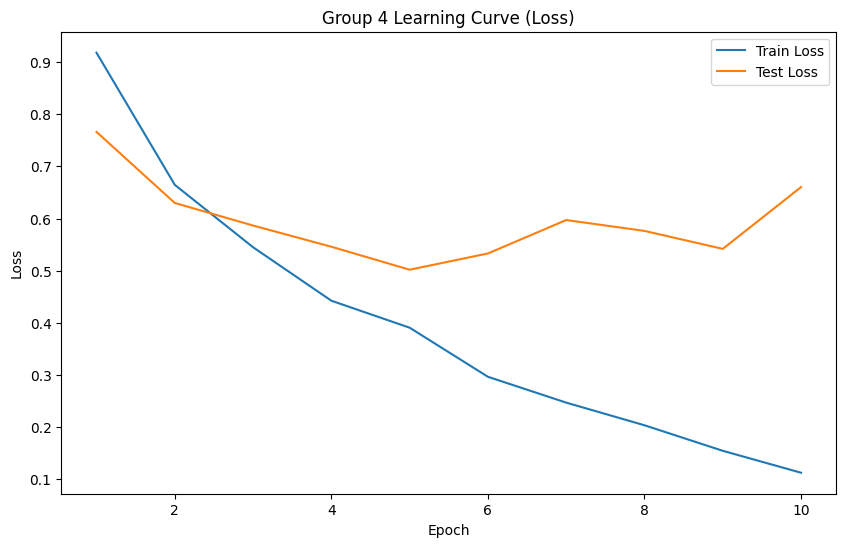

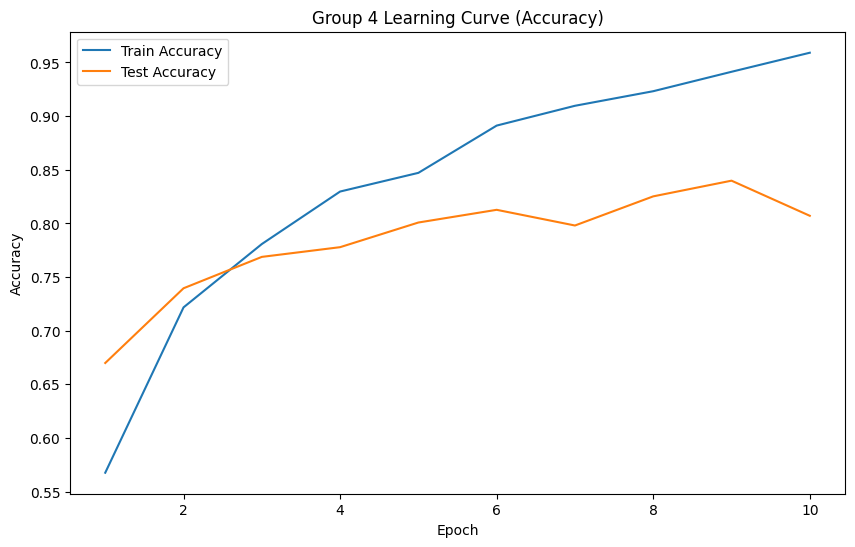

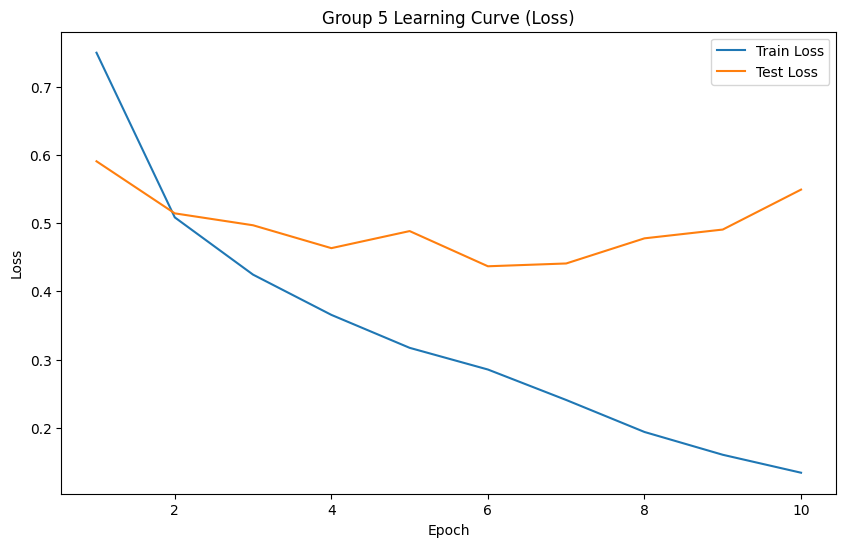

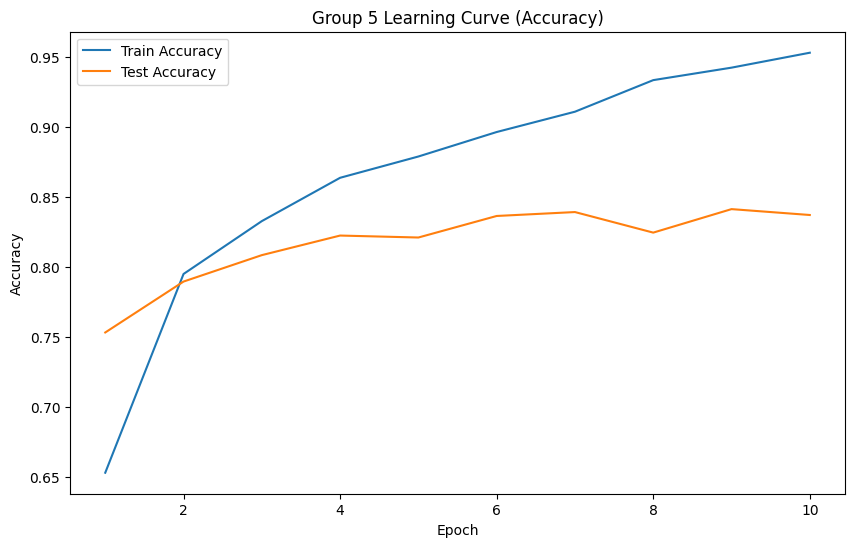

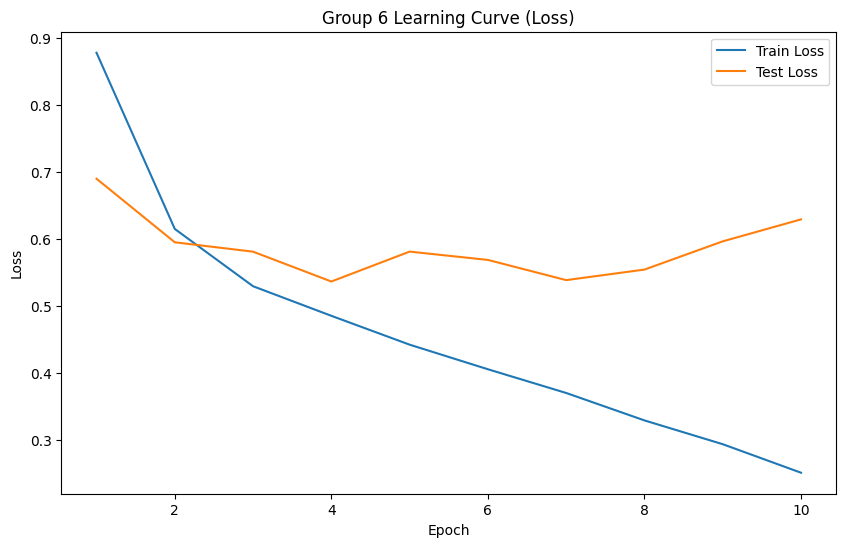

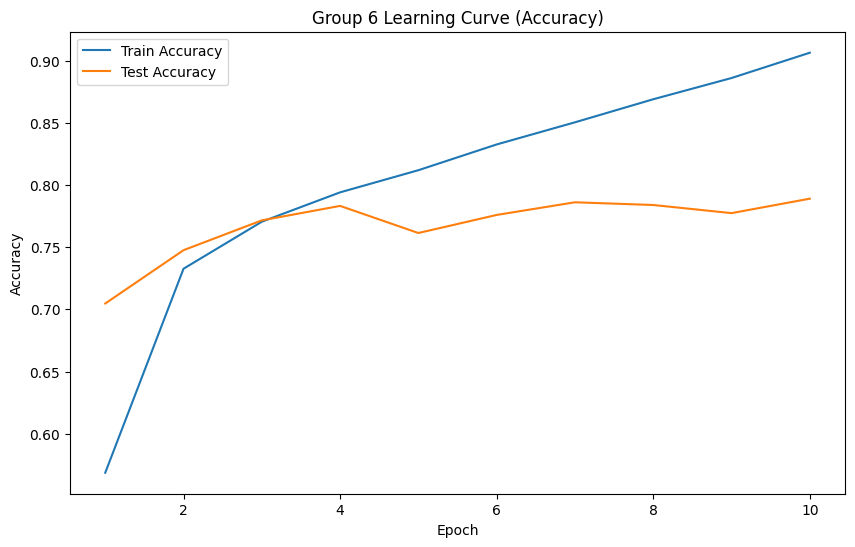

In [11]:
# Learning Curve 그리기
for curve in all_learning_curves:
    group_idx = curve["Group"]
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, EPOCHS + 1), curve["train_losses"], label="Train Loss")
    plt.plot(range(1, EPOCHS + 1), curve["test_losses"], label="Test Loss")
    plt.title(f"Group {group_idx} Learning Curve (Loss)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, EPOCHS + 1), curve["train_accuracies"], label="Train Accuracy")
    plt.plot(range(1, EPOCHS + 1), curve["test_accuracies"], label="Test Accuracy")
    plt.title(f"Group {group_idx} Learning Curve (Accuracy)")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

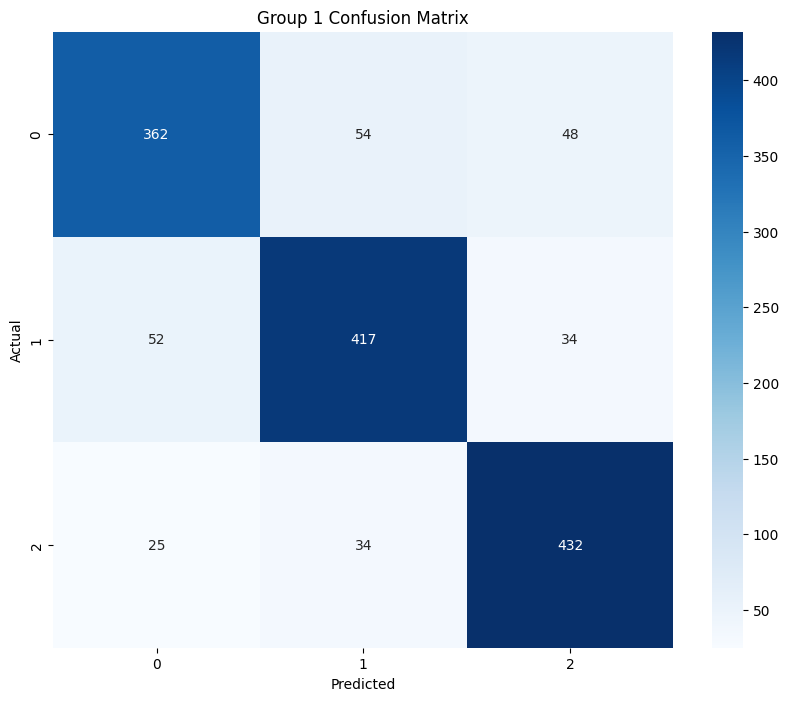

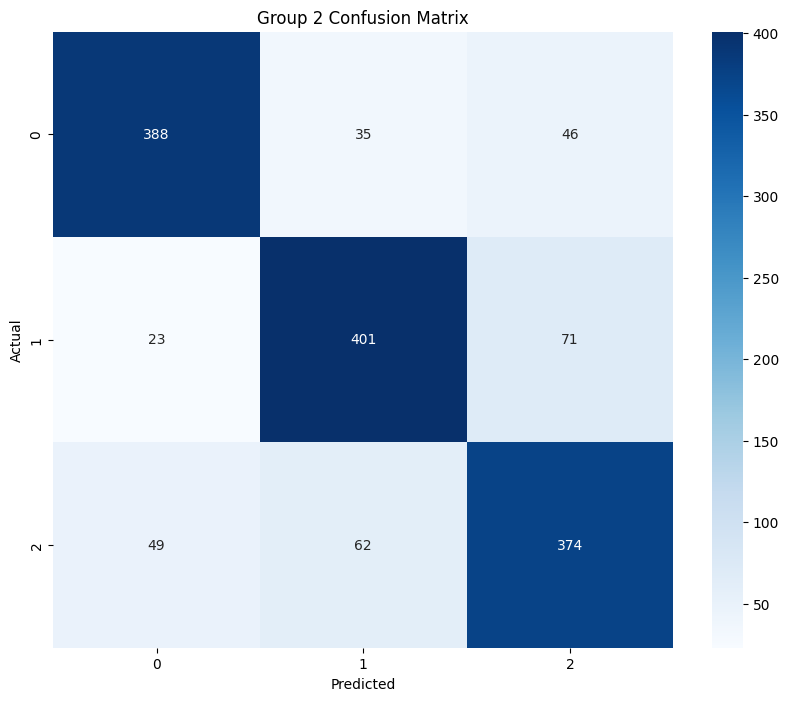

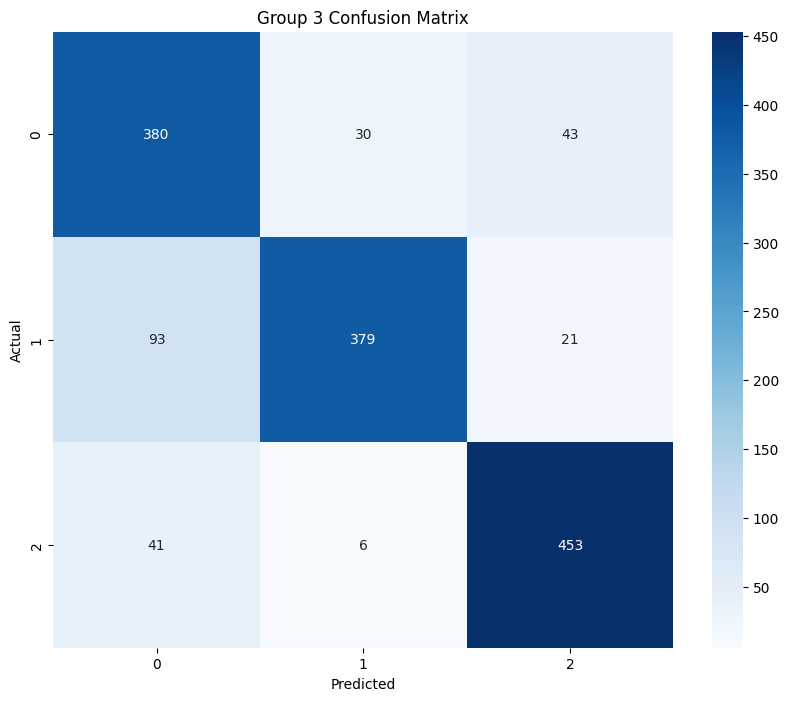

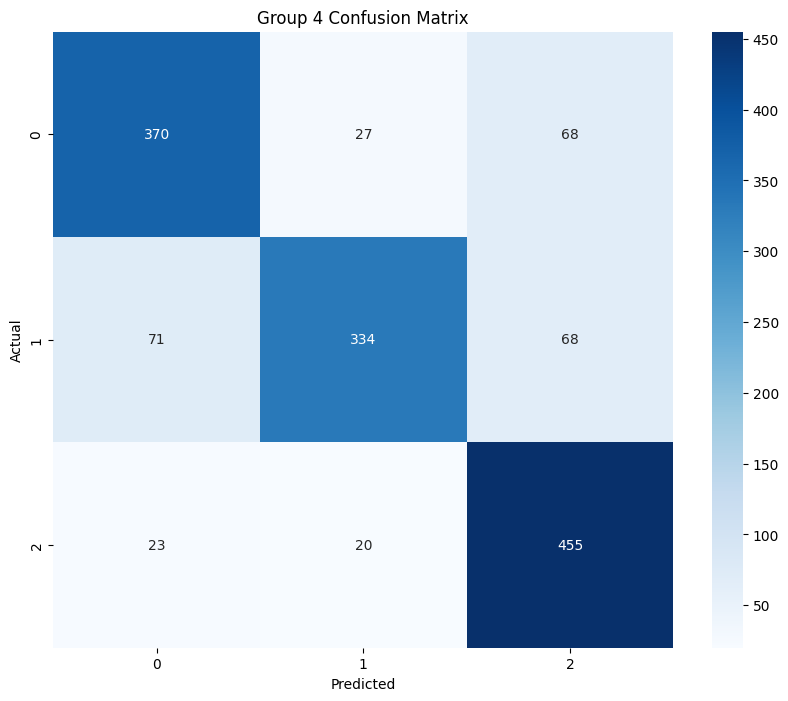

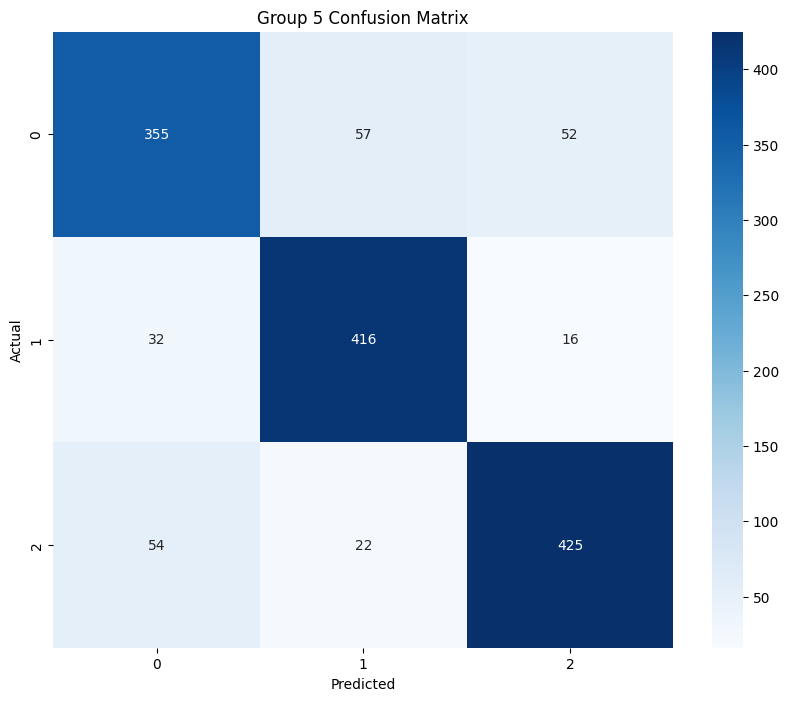

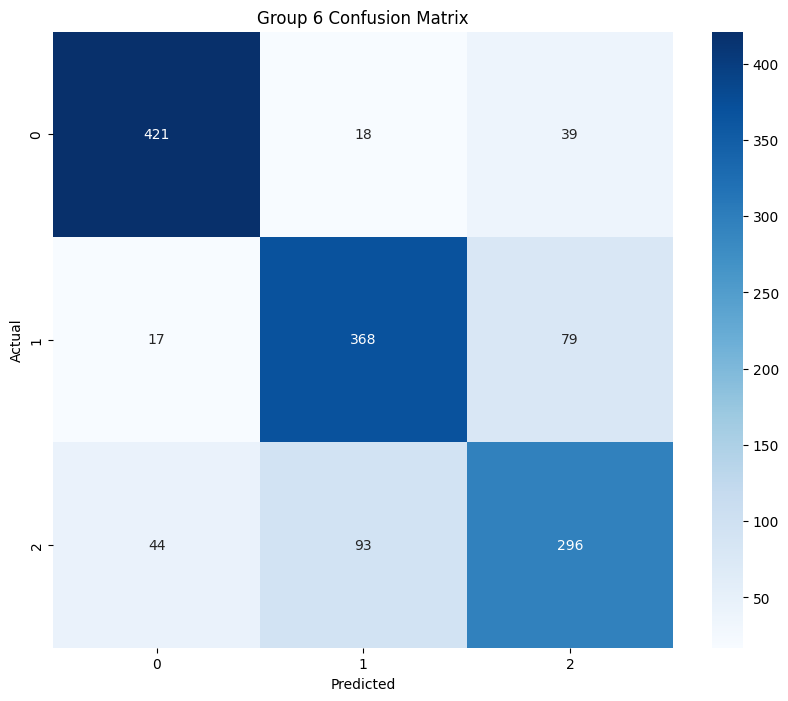

In [12]:
# Confusion Matrix 그리기
for result in results:
    group_idx = result["Group"]
    cm = result["Confusion Matrix"]
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(df['Label'].unique()), yticklabels=sorted(df['Label'].unique()))
    plt.title(f"Group {group_idx} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()